# Convert a TensorFlow Object Detection Model to OpenVINO™

[TensorFlow](https://www.tensorflow.org/), or TF for short, is an open-source framework for machine learning.

The [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) is an open-source computer vision framework built on top of TensorFlow. It is used for building object detection and image segmentation models that can localize multiple objects in the same image. TensorFlow Object Detection API supports various architectures and models, which can be found and downloaded from the [TensorFlow Hub](https://tfhub.dev/tensorflow/collections/object_detection/1).

This tutorial shows how to convert a TensorFlow [Faster R-CNN with Resnet-50 V1](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1) object detection model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_IR_and_opsets.html) (OpenVINO IR) format, using Model Converter. After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/nightly/openvino_docs_OV_UG_OV_Runtime_User_Guide.html) and do inference with a sample image.

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Imports](#Imports)
- [Settings](#Settings)
- [Download Model from TensorFlow Hub](#Download-Model-from-TensorFlow-Hub)
- [Convert Model to OpenVINO IR](#Convert-Model-to-OpenVINO-IR)
- [Test Inference on the Converted Model](#Test-Inference-on-the-Converted-Model)
- [Select inference device](#Select-inference-device)
    - [Load the Model](#Load-the-Model)
    - [Get Model Information](#Get-Model-Information)
    - [Get an Image for Test Inference](#Get-an-Image-for-Test-Inference)
    - [Perform Inference](#Perform-Inference)
    - [Inference Result Visualization](#Inference-Result-Visualization)
- [Next Steps](#Next-Steps)
    - [Async inference pipeline](#Async-inference-pipeline)
    - [Integration preprocessing to model](#Integration-preprocessing-to-model)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages:

In [1]:
%pip install -q "openvino>=2023.1.0" "numpy>=1.21.0" "opencv-python" "matplotlib>=3.4"

The notebook uses utility functions.
The cell below will download the `notebook_utils` Python module from GitHub.

In [2]:
# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request

urllib.request.urlretrieve(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py",
    filename="notebook_utils.py",
);

## Imports
[back to top ⬆️](#Table-of-contents:)


In [3]:
# Standard python modules
from pathlib import Path

# External modules and dependencies
import cv2
import matplotlib.pyplot as plt
import numpy as np
# OpenVINO import
import openvino as ov

# Notebook utils module
from notebook_utils import download_file

## Settings
[back to top ⬆️](#Table-of-contents:)

Define model related variables and create corresponding directories:

In [4]:
# Create directories for models files
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# Create directory for TensorFlow model
tf_model_dir = model_dir / "tf"
tf_model_dir.mkdir(exist_ok=True)

# Create directory for OpenVINO IR model
ir_model_dir = model_dir / "ir"
ir_model_dir.mkdir(exist_ok=True)

model_name = "faster_rcnn_resnet50_v1_640x640"

openvino_ir_path = ir_model_dir / f"{model_name}.xml"

tf_model_url = "https://www.kaggle.com/models/tensorflow/faster-rcnn-resnet-v1/frameworks/tensorFlow2/variations/faster-rcnn-resnet50-v1-640x640/versions/1?tf-hub-format=compressed"

tf_model_archive_filename = f"{model_name}.tar.gz"

## Download Model from TensorFlow Hub
[back to top ⬆️](#Table-of-contents:)

Download archive with TensorFlow Object Detection model ([faster_rcnn_resnet50_v1_640x640](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1)) from TensorFlow Hub:

In [5]:
download_file(
    url=tf_model_url,
    filename=tf_model_archive_filename,
    directory=tf_model_dir
)

model/tf/faster_rcnn_resnet50_v1_640x640.tar.gz:   0%|          | 0.00/101M [00:00<?, ?B/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Extract TensorFlow Object Detection model from the downloaded archive:

In [6]:
import tarfile

with tarfile.open(tf_model_dir / tf_model_archive_filename) as file:
    file.extractall(path=tf_model_dir)

## Convert Model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

OpenVINO Model Converter Python API can be used to convert the TensorFlow model to OpenVINO IR. 

`ov.convert_model` function accept path to TensorFlow model and returns OpenVINO Model class instance which represents this model.
Also we need to provide model input shape (`input_shape`) that is described at [model overview page on TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1). 

The converted model is ready to load on a device using `compile_model` or saved on disk using the `save_model` function to reduce loading time when the model is run in the future. 

See the [Model Converter Developer Guide](https://docs.openvino.ai/2023.1/openvino_docs_model_processing_introduction.html) for more information about Model Converter and TensorFlow [models support](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_TensorFlow.html).

In [7]:
ov_model = ov.convert_model(tf_model_dir)

# Save converted OpenVINO IR model to the corresponding directory
ov.save_model(ov_model, openvino_ir_path)

## Test Inference on the Converted Model
[back to top ⬆️](#Table-of-contents:)


## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

### Load the Model
[back to top ⬆️](#Table-of-contents:)


In [9]:
core = ov.Core()
openvino_ir_model = core.read_model(openvino_ir_path)
compiled_model = core.compile_model(model=openvino_ir_model, device_name=device.value)

### Get Model Information
[back to top ⬆️](#Table-of-contents:)

Faster R-CNN with Resnet-50 V1 object detection model has one input - a three-channel image of variable size. The input tensor shape is `[1, height, width, 3]` with values in `[0, 255]`.

Model output dictionary contains several tensors:

- `num_detections` - the number of detections in `[N]` format.
- `detection_boxes` - bounding box coordinates for all `N` detections in `[ymin, xmin, ymax, xmax]` format.
- `detection_classes` - `N` detection class indexes size from the label file.
- `detection_scores` - `N` detection scores (confidence) for each detected class.
- `raw_detection_boxes` - decoded detection boxes without Non-Max suppression.
- `raw_detection_scores` - class score logits for raw detection boxes.
- `detection_anchor_indices` - the anchor indices of the detections after NMS.
- `detection_multiclass_scores` - class score distribution (including background) for detection boxes in the image including background class.

In this tutorial we will mostly use `detection_boxes`, `detection_classes`, `detection_scores` tensors. It is important to mention, that values of these tensors correspond to each other and are ordered by the highest detection score: the first detection box corresponds to the first detection class and to the first (and highest) detection score.

See the [model overview page on TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1) for more information about model inputs, outputs and their formats.

In [10]:
model_inputs = compiled_model.inputs
model_input = compiled_model.input(0)
model_outputs = compiled_model.outputs

print("Model inputs count:", len(model_inputs))
print("Model input:", model_input)

print("Model outputs count:", len(model_outputs))
print("Model outputs:")
for output in model_outputs:
    print("  ", output)

Model inputs count: 1
Model input: <ConstOutput: names[input_tensor] shape[1,?,?,3] type: u8>
Model outputs count: 8
Model outputs:
   <ConstOutput: names[detection_anchor_indices] shape[1,?] type: f32>
   <ConstOutput: names[detection_boxes] shape[1,?,..8] type: f32>
   <ConstOutput: names[detection_classes] shape[1,?] type: f32>
   <ConstOutput: names[detection_multiclass_scores] shape[1,?,..182] type: f32>
   <ConstOutput: names[detection_scores] shape[1,?] type: f32>
   <ConstOutput: names[num_detections] shape[1] type: f32>
   <ConstOutput: names[raw_detection_boxes] shape[1,300,4] type: f32>
   <ConstOutput: names[raw_detection_scores] shape[1,300,91] type: f32>


### Get an Image for Test Inference
[back to top ⬆️](#Table-of-contents:)

Load and save an image:

In [11]:
image_path = Path("./data/coco_bike.jpg")

download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
    filename=image_path.name,
    directory=image_path.parent,
)

'data/coco_bike.jpg' already exists.


PosixPath('/home/ea/work/openvino_notebooks/notebooks/120-tensorflow-object-detection-to-openvino/data/coco_bike.jpg')

Read the image, resize and convert it to the input shape of the network:

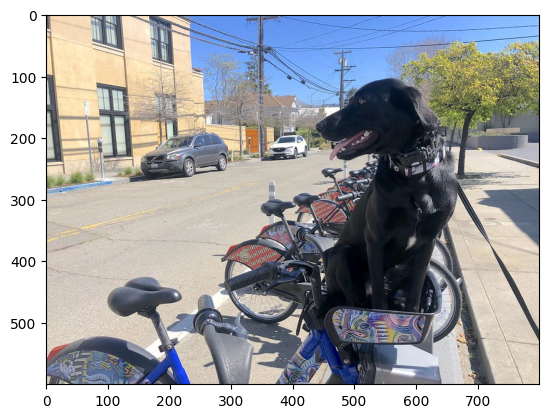

In [12]:
# Read the image
image = cv2.imread(filename=str(image_path))

# The network expects images in RGB format
image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape
resized_image = cv2.resize(src=image, dsize=(255, 255))

# Transpose the image to the network input shape
network_input_image = np.expand_dims(resized_image, 0)

# Show the image
plt.imshow(image)

### Perform Inference
[back to top ⬆️](#Table-of-contents:)


In [13]:
inference_result = compiled_model(network_input_image)

After model inference on the test image, object detection data can be extracted from the result.
For further model result visualization `detection_boxes`, `detection_classes` and `detection_scores` outputs will be used.

In [14]:
_, detection_boxes, detection_classes, _, detection_scores, num_detections, _, _ = model_outputs

image_detection_boxes = inference_result[detection_boxes]
print("image_detection_boxes:", image_detection_boxes)

image_detection_classes = inference_result[detection_classes]
print("image_detection_classes:", image_detection_classes)

image_detection_scores = inference_result[detection_scores]
print("image_detection_scores:", image_detection_scores)

image_num_detections = inference_result[num_detections]
print("image_detections_num:", image_num_detections)

# Alternatively, inference result data can be extracted by model output name with `.get()` method
assert (inference_result[detection_boxes] == inference_result.get("detection_boxes")).all(), "extracted inference result data should be equal"

image_detection_boxes: [[[0.1645457  0.54601336 0.8953864  0.85500604]
  [0.67189544 0.01240015 0.9843237  0.53085935]
  [0.49188587 0.0117609  0.98050654 0.8866383 ]
  ...
  [0.43604603 0.59332204 0.4692565  0.6341099 ]
  [0.46022677 0.59246916 0.48732638 0.61871874]
  [0.47092935 0.4351712  0.5583364  0.5072162 ]]]
image_detection_classes: [[18.  2.  2.  3.  2.  8.  2.  2.  3.  2.  4.  4.  2.  4. 16.  1.  1.  2.
  27.  8. 62.  2.  2.  4.  4.  2. 18. 41.  4.  4.  2. 18.  2.  2.  4.  2.
  27.  2. 27.  2.  1.  2. 16.  1. 16.  2.  2.  2.  2. 16.  2.  2.  4.  2.
   1. 33.  4. 15.  3.  2.  2.  1.  2.  1.  4.  2.  3. 11.  4. 35.  4.  1.
  40.  2. 62.  2.  4.  4. 36.  1. 36. 36. 31. 77.  2.  1. 51.  1. 34.  3.
   2.  3. 90.  2.  1.  2.  1.  2.  1.  1.  2.  4. 18.  2.  3.  2. 31.  1.
   1.  2.  2. 33. 41. 41. 31.  3.  1. 36.  3. 15. 27. 27.  4.  4.  2. 37.
   3. 15.  1. 35. 27.  4. 36.  4. 88.  3.  2. 15.  2.  4.  2.  1.  3.  4.
  27.  4.  3. 16. 44.  1.  1. 23.  4.  1.  4.  3.  4. 15. 62. 36

### Inference Result Visualization
[back to top ⬆️](#Table-of-contents:)

Define utility functions to visualize the inference results

In [15]:
import random
from typing import Optional


def add_detection_box(box: np.ndarray, image: np.ndarray, label: Optional[str] = None) -> np.ndarray:
    """
    Helper function for adding single bounding box to the image

    Parameters
    ----------
    box : np.ndarray
        Bounding box coordinates in format [ymin, xmin, ymax, xmax]
    image : np.ndarray
        The image to which detection box is added
    label : str, optional
        Detection box label string, if not provided will not be added to result image (default is None)

    Returns
    -------
    np.ndarray
        NumPy array including both image and detection box

    """
    ymin, xmin, ymax, xmax = box
    point1, point2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
    box_color = [random.randint(0, 255) for _ in range(3)]
    line_thickness = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1

    cv2.rectangle(img=image, pt1=point1, pt2=point2, color=box_color, thickness=line_thickness, lineType=cv2.LINE_AA)

    if label:
        font_thickness = max(line_thickness - 1, 1)
        font_face = 0
        font_scale = line_thickness / 3
        font_color = (255, 255, 255)
        text_size = cv2.getTextSize(text=label, fontFace=font_face, fontScale=font_scale, thickness=font_thickness)[0]
        # Calculate rectangle coordinates
        rectangle_point1 = point1
        rectangle_point2 = (point1[0] + text_size[0], point1[1] - text_size[1] - 3)
        # Add filled rectangle
        cv2.rectangle(img=image, pt1=rectangle_point1, pt2=rectangle_point2, color=box_color, thickness=-1, lineType=cv2.LINE_AA)
        # Calculate text position
        text_position = point1[0], point1[1] - 3
        # Add text with label to filled rectangle
        cv2.putText(img=image, text=label, org=text_position, fontFace=font_face, fontScale=font_scale, color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)
    return image

In [16]:
from typing import Dict

from openvino.runtime.utils.data_helpers import OVDict


def visualize_inference_result(inference_result: OVDict, image: np.ndarray, labels_map: Dict, detections_limit: Optional[int] = None):
    """
    Helper function for visualizing inference result on the image

    Parameters
    ----------
    inference_result : OVDict
        Result of the compiled model inference on the test image
    image : np.ndarray
        Original image to use for visualization
    labels_map : Dict
        Dictionary with mappings of detection classes numbers and its names
    detections_limit : int, optional
        Number of detections to show on the image, if not provided all detections will be shown (default is None)
    """
    detection_boxes: np.ndarray = inference_result.get("detection_boxes")
    detection_classes: np.ndarray = inference_result.get("detection_classes")
    detection_scores: np.ndarray = inference_result.get("detection_scores")
    num_detections: np.ndarray = inference_result.get("num_detections")

    detections_limit = int(
        min(detections_limit, num_detections[0])
        if detections_limit is not None
        else num_detections[0]
    )

    # Normalize detection boxes coordinates to original image size
    original_image_height, original_image_width, _ = image.shape
    normalized_detection_boxex = detection_boxes[::] * [
        original_image_height,
        original_image_width,
        original_image_height,
        original_image_width,
    ]

    image_with_detection_boxex = np.copy(image)

    for i in range(detections_limit):
        detected_class_name = labels_map[int(detection_classes[0, i])]
        score = detection_scores[0, i]
        label = f"{detected_class_name} {score:.2f}"
        add_detection_box(
            box=normalized_detection_boxex[0, i],
            image=image_with_detection_boxex,
            label=label,
        )

    plt.imshow(image_with_detection_boxex)

TensorFlow Object Detection model ([faster_rcnn_resnet50_v1_640x640](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1)) used in this notebook was trained on [COCO 2017](https://cocodataset.org/) dataset with 91 classes.
For better visualization experience we can use COCO dataset labels with human readable class names instead of class numbers or indexes. 

We can download COCO dataset classes labels from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/):

In [17]:
coco_labels_file_path = Path("./data/coco_91cl.txt")

download_file(
    url="https://raw.githubusercontent.com/openvinotoolkit/open_model_zoo/master/data/dataset_classes/coco_91cl.txt",
    filename=coco_labels_file_path.name,
    directory=coco_labels_file_path.parent,
)

data/coco_91cl.txt:   0%|          | 0.00/421 [00:00<?, ?B/s]

PosixPath('/home/ea/work/openvino_notebooks/notebooks/120-tensorflow-object-detection-to-openvino/data/coco_91cl.txt')

Then we need to create dictionary `coco_labels_map` with mappings between detection classes numbers and its names from the downloaded file:

In [18]:
with open(coco_labels_file_path, "r") as file:
    coco_labels = file.read().strip().split("\n")
    coco_labels_map = dict(enumerate(coco_labels, 1))

print(coco_labels_map)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplan', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'street sign', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'plate', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'mirror', 67: 'dining table', 68: 'window', 69: 'des

Finally, we are ready to visualize model inference results on the original test image:

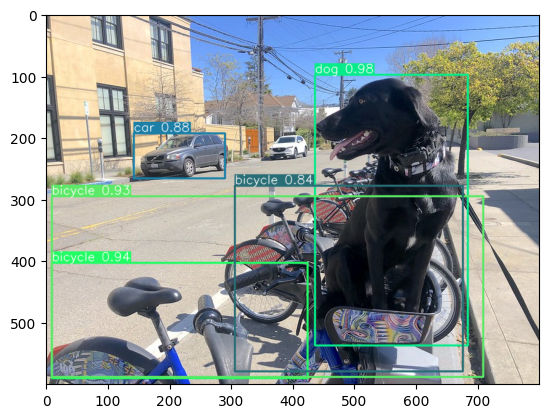

In [19]:
visualize_inference_result(
    inference_result=inference_result,
    image=image,
    labels_map=coco_labels_map,
    detections_limit=5,
)

## Next Steps
[back to top ⬆️](#Table-of-contents:)

This section contains suggestions on how to additionally improve the performance of your application using OpenVINO.

### Async inference pipeline
[back to top ⬆️](#Table-of-contents:)
The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to the [Async API tutorial](../115-async-api/115-async-api.ipynb).

### Integration preprocessing to model
[back to top ⬆️](#Table-of-contents:)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries. 
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will improve selected device utilization.

For more information, refer to the [Optimize Preprocessing tutorial](../118-optimize-preprocessing/118-optimize-preprocessing.ipynb) and to the overview of [Preprocessing API](https://docs.openvino.ai/2023.0/openvino_docs_OV_Runtime_UG_Preprocessing_Overview.html).
